## OBJECTIVE : 

### Prepare classification model for classifying comments into various categories : toxic, severe_toxic, obscene, threat, insult, identity_hate

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

Numpy Version :  1.18.2
Pandas Version :  1.0.3
Matplotlib Version :  3.2.1


In [3]:
from joblib import load
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

In [4]:
sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [5]:
import utils.text_processing as tp
from config import GLOVE_PATH, MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, VALIDATION_SPLIT, BATCH_SIZE, EPOCHS

In [6]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [7]:
TRAIN_DIR = os.path.join(DATA_DIR, "training_data/word_2_index/")

In [8]:
CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [9]:
train_data = pd.read_csv(os.path.join(TRAIN_DIR, "vectors_complex.csv"), encoding="utf-8")

In [10]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0,0,0,0,0,...,2,2058,16,15,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,697,9,4,91,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,218,571,76,302,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,17,1,680,2996,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2140,677,371,2,0,0,0,0,0,0


In [11]:
X = train_data[[str(i) for i in np.arange(0, 100, 1)]].values
y = train_data[CLASSES].values

In [12]:
X.shape, y.shape

((159356, 100), (159356, 6))

In [13]:
X

array([[   0,    0,    0, ..., 2058,   16,   15],
       [   0,    0,    0, ...,    9,    4,   91],
       [   0,    0,    0, ...,  571,   76,  302],
       ...,
       [   0,    0,    0, ..., 2029, 9403, 2902],
       [   0,    0,    0, ...,  189,   18,   27],
       [   0,    0,    0, ...,  206,   30,  958]])

In [14]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [15]:
tokenizer = load(os.path.join(OBJECT_DIR, "tokenizer.joblib"))

In [16]:
word_ind_dict = tokenizer.word_index

In [17]:
GLOVE_PATH = "/home/praveen/pk_works/nlp/glove"
GLOVE_PATH = os.path.join(GLOVE_PATH, "glove.6B.{}d.txt".format(EMBEDDING_DIM))
GLOVE_PATH

'/home/praveen/pk_works/nlp/glove/glove.6B.100d.txt'

In [18]:
num_words = min(MAX_VOCAB_SIZE, len(word_ind_dict) + 1)

In [19]:
num_words

20000

In [20]:
len(word_ind_dict)

151081

In [21]:
embed_matrix = tp.get_embedding_matrix(GLOVE_PATH, word_ind_dict, num_words, EMBEDDING_DIM, MAX_VOCAB_SIZE)

In [22]:
embed_layer = tp.get_embedding_layer(num_words, EMBEDDING_DIM, embed_matrix, MAX_SEQUENCE_LENGTH)

In [23]:
embed_matrix.shape

(20000, 100)

In [24]:
embed_layer.get_config()

{'name': 'embedding',
 'trainable': False,
 'batch_input_shape': (None, 100),
 'dtype': 'float32',
 'input_dim': 20000,
 'output_dim': 100,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': 100}

In [27]:
num_words, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH

(20000, 100, 100)

In [28]:
def create_model():
    # train a 1D convnet with global maxpooling
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(len(CLASSES), activation='sigmoid')(x)
    model = Model(input_, output)
    return model

In [29]:
model = create_model()

In [30]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': False,
    'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'input_dim': 20000,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 100},
   'name': 'embedding',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 128,
    'kernel_size': (3,),
    'strides': (1,),
    'padding': 'valid',
    'dat

In [31]:
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [32]:
history = model.fit(
  X,
  y,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Train on 127484 samples, validate on 31872 samples
Epoch 1/10
127484/127484 [==============================] - 12s 97us/sample - loss: 0.0874 - accuracy: 0.9727 - val_loss: 0.0852 - val_accuracy: 0.9741
Epoch 2/10
127484/127484 [==============================] - 6s 44us/sample - loss: 0.0733 - accuracy: 0.9761 - val_loss: 0.0755 - val_accuracy: 0.9755
Epoch 3/10
127484/127484 [==============================] - 6s 45us/sample - loss: 0.0692 - accuracy: 0.9771 - val_loss: 0.0766 - val_accuracy: 0.9759
Epoch 4/10
127484/127484 [==============================] - 6s 45us/sample - loss: 0.0657 - accuracy: 0.9781 - val_loss: 0.0800 - val_accuracy: 0.9757
Epoch 5/10
127484/127484 [==============================] - 6s 45us/sample - loss: 0.0632 - accuracy: 0.9788 - val_loss: 0.0838 - val_accuracy: 0.9758
Epoch 6/10
127484/127484 [==============================] - 6s 46us/sample - loss: 0.0611 - accuracy: 0.9793 - val_loss: 0.0813 - val_accuracy: 0.9757
Epoch 7/10
127484/127484 [================

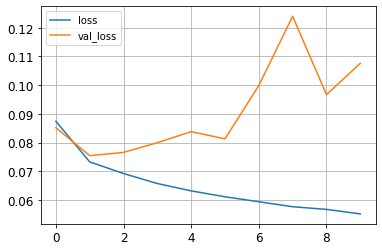

In [36]:
# plot some data
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

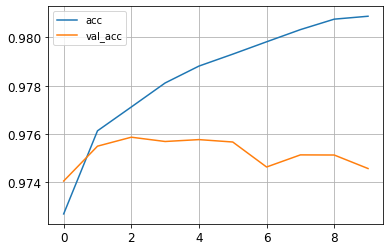

In [39]:
# accuracies
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.grid()
plt.show()

In [40]:
# plot the mean AUC over each label
p = model.predict(X)
aucs = []
for j in range(6):
    auc = roc_auc_score(y[:,j], y[:,j])
    aucs.append(auc)
print(np.mean(aucs))

1.0


In [41]:
aucs

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]